# Deep Learning Computer Vision Experiments
These Jupyter Notebooks are a walkthrough to Deep Learning Computer Vision applications using [FastAI Version 2](https://github.com/fastai/fastai2). For each of the applications data generators are used. This eliminates the need for external data sets and facilitates scalability explorations.
## Full-Image Classification
Full-image Classification is the task of assigning a category label to an image. Given are photographs of objects in which there is one prominent object shown around the center of the image. Typically, this object is also the largest object in the image. Let's create a data set containing number digits as the primary object in each image (excluding backgroud structures such as sky).

To make this experiment a little bit more interesting the digits are drawn from random fonts and corrupted with a data augmentation pipline. One set of images is saved and cleaned up so one can actually skip this notebook and move on with the training. You can run this notebook again to add more samples. Note, that you have to clean up manually.
### Important imports
Install all Python packages such that the following code section runs through smoothly.

In [1]:
%matplotlib inline
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
import random
import string

### Experiments to get a random digit image

In [2]:
im_size = 64
image = Image.new('L', (im_size, im_size), 0)

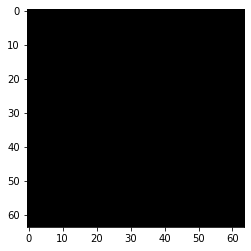

In [3]:
plt.imshow(np.asarray(image), cmap='gray')

In [4]:
path_fonts = Path(r"C:\Windows\Fonts") # enter your font path here

In [5]:
fonts = list(path_fonts.rglob("*.ttf"))

In [6]:
len(fonts)

489

In [7]:
fonts[0:5]

[WindowsPath('C:/Windows/Fonts/AGENCYB.TTF'),
 WindowsPath('C:/Windows/Fonts/AGENCYR.TTF'),
 WindowsPath('C:/Windows/Fonts/Alef-Bold.ttf'),
 WindowsPath('C:/Windows/Fonts/Alef-Regular.ttf'),
 WindowsPath('C:/Windows/Fonts/ALGER.TTF')]

The following code to fit the digit's size to the image is heavily inspired from [here](https://stackoverflow.com/questions/4902198/pil-how-to-scale-text-size-in-relation-to-the-size-of-the-image.) 

In [9]:
font_height = 0
margin = 10
font = ImageFont.truetype(str(fonts[1]), font_height)
while font.getsize("1")[1] < im_size-margin:
    font = ImageFont.truetype(str(fonts[1]), font_height)
    font_height += 1
font_height

55

In [10]:
ImageDraw.Draw(image).text((0, 0), "1", font=font, fill=255)

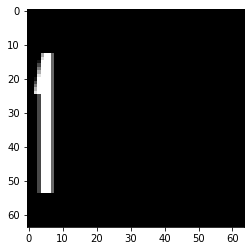

In [11]:
plt.imshow(np.asarray(image), cmap='gray')

### Definition of a random image generation function

In [12]:
def get_random_digit_image(fonts, im_size, margin, bg_max, fg_min):
    img = Image.new('L', (im_size, im_size), random.randrange(0, bg_max))
    digit = str(random.randrange(0, 10))
    font_height = 0
    idx = random.randrange(0, len(fonts))
    font = ImageFont.truetype(str(fonts[idx]), 0)
    while font.getsize(digit)[1] < im_size-2*margin:
        font = ImageFont.truetype(str(fonts[idx]), font_height)
        font_height += 1
    font = ImageFont.truetype(str(fonts[idx]), font_height-1)
    font_size = font.getsize(digit)
    ImageDraw.Draw(img).text(
        ((im_size-font_size[0])/2, (im_size-font_size[1])/2),
        digit,
        font=font,
        fill=random.randrange(fg_min, 255)
    )
    return img, digit

In [13]:
image, d = get_random_digit_image(fonts, im_size, margin, 100, 105)

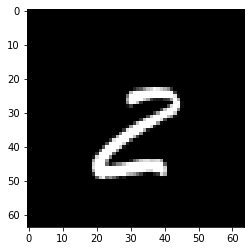

In [14]:
plt.imshow(np.asarray(image), cmap='gray')

In [15]:
d

'2'

### Definition of a data augmentation pipeline based on [imgaug](https://imgaug.readthedocs.io/en/latest/)
Data augmentation pipeline stolen from [here](https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-standard-use-case) and tamed (set to be less corruptive). 

In [16]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-15, 15),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        iaa.SomeOf((0, 5),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.15)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [17]:
all_images_and_idxs= [get_random_digit_image(fonts, im_size, margin, 100, 105) for i in range(200)]

In [18]:
all_images_np = [np.asarray(im[0]) for im in all_images_and_idxs]

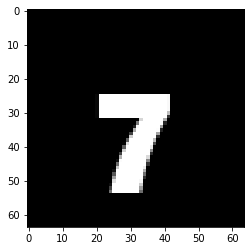

In [19]:
plt.imshow(all_images_np[42], cmap='gray')

In [20]:
images_aug = seq(images=all_images_np)

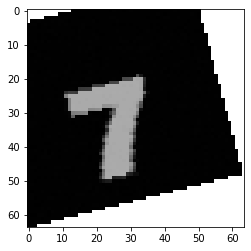

In [21]:
plt.imshow(images_aug[42], cmap='gray')

In [25]:
all_idxs = [im[1] for im in all_images_and_idxs]

In [26]:
all_idxs[0:10]

['0', '8', '0', '3', '3', '8', '5', '6', '7', '8']

In [28]:
#https://stackoverflow.com/questions/2257441/random-string-generation-with-upper-case-letters-and-digits
def random_string(length=5):
  return ''.join(random.sample(string.ascii_lowercase, length))
random_string()

'msqru'

In [29]:
%mkdir 00_classifier_images

In [30]:
for k in range(len(all_idxs)):
    im = Image.fromarray(all_images_np[k])
    im.save("00_classifier_images/"+all_idxs[k]+"_"+random_string()+".jpeg")